In [1]:
from gensim.models.fasttext import load_facebook_model
from gensim.models.fasttext import load_facebook_vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn
import optuna

In [2]:
# load FastText model
fasttext_model = load_facebook_vectors('../../Downloads/CHEME DIRECT/NLP Project/cc.en.300.bin')

In [3]:
class FastTextVectorizer:
    def __init__(self, fasttext_model):
        self.fasttext_model = fasttext_model

    def transform(self, X):
        return np.array([
            np.mean([self.fasttext_model[w] for w in words.split() if w in self.fasttext_model]
                    or [np.zeros(self.fasttext_model.vector_size)], axis=0)
            for words in X
        ])

In [4]:
# load dataset
df1 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='SamePerson Report')
df2 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Report')
df3 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Less Details')

In [5]:
dev_1, test_1 = sklearn.model_selection.train_test_split(df1, test_size=0.2, random_state=26)
dev_2, test_2 = sklearn.model_selection.train_test_split(df2, test_size=0.2, random_state=26)
dev_3, test_3 = sklearn.model_selection.train_test_split(df3, test_size=0.2, random_state=26)

In [6]:
dev_1_text = dev_1['Report'].values.reshape(-1,1)
test_1_text = test_1['Report'].values.reshape(-1,1)

dev_1_label = dev_1['Level'].values.reshape(-1,1)
test_1_label = test_1['Level'].values.reshape(-1,1)

dev_2_text = dev_2['Report'].values.reshape(-1,1)
test_2_text = test_2['Report'].values.reshape(-1,1)

dev_2_label = dev_2['Level'].values.reshape(-1,1)
test_2_label = test_2['Level'].values.reshape(-1,1)

dev_3_text = dev_3['Report'].values.reshape(-1,1)
test_3_text = test_3['Report'].values.reshape(-1,1)

dev_3_label = dev_3['Level'].values.reshape(-1,1)
test_3_label = test_3['Level'].values.reshape(-1,1)

In [7]:
dev_1_text_list = dev_1_text.tolist()
dev_1_text_str = [item for sublist in dev_1_text_list for item in sublist]

test_1_text_list = test_1_text.tolist()
test_1_text_str = [item for sublist in test_1_text_list for item in sublist]

dev_1_label_list = dev_1_label.tolist()
dev_1_label_str = [item for sublist in dev_1_label_list for item in sublist]

test_1_label_list = test_1_label.tolist()
test_1_label_str = [item for sublist in test_1_label_list for item in sublist]

In [8]:
dev_2_text_list = dev_2_text.tolist()
dev_2_text_str = [item for sublist in dev_2_text_list for item in sublist]

test_2_text_list = test_2_text.tolist()
test_2_text_str = [item for sublist in test_2_text_list for item in sublist]

dev_2_label_list = dev_2_label.tolist()
dev_2_label_str = [item for sublist in dev_2_label_list for item in sublist]

test_2_label_list = test_2_label.tolist()
test_2_label_str = [item for sublist in test_2_label_list for item in sublist]

In [9]:
dev_3_text_list = dev_3_text.tolist()
dev_3_text_str = [item for sublist in dev_3_text_list for item in sublist]

test_3_text_list = test_3_text.tolist()
test_3_text_str = [item for sublist in test_3_text_list for item in sublist]

dev_3_label_list = dev_3_label.tolist()
dev_3_label_str = [item for sublist in dev_3_label_list for item in sublist]

test_3_label_list = test_3_label.tolist()
test_3_label_str = [item for sublist in test_3_label_list for item in sublist]

In [10]:
dev_text = dev_1_text_str + dev_2_text_str + dev_3_text_str
test_text = test_1_text_str + test_2_text_str + test_3_text_str

dev_label = dev_1_label_str + dev_2_label_str + dev_3_label_str
test_label = test_1_label_str + test_2_label_str + test_3_label_str

In [11]:
# Transform raw text data to vectors
vectorizer = FastTextVectorizer(fasttext_model)
dev_text_ft = vectorizer.transform(dev_text)
test_text_ft = vectorizer.transform(test_text)

In [16]:
train_x, val_x, train_y, val_y = sklearn.model_selection.train_test_split(
    dev_text_ft, dev_label, test_size=0.2, random_state=26)

In [22]:
def train_evaluate_hyperparameters(n_estimators, max_depth, min_weight_fraction_leaf):
    # create model
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf)
    # train the model on the training set
    model.fit(train_x, train_y)
    # evaluate the model on the validation set
    score = model.score(val_x, val_y)
    return score

In [23]:
def objective(trial):
    # define hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)
    max_depth = trial.suggest_int('max_depth', 1, 600)
    min_weight_fraction_leaf = trial.suggest_uniform(
        'min_weight_fraction_leaf', 0.0, 0.5)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(n_estimators, max_depth, min_weight_fraction_leaf)
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

[I 2023-06-05 11:11:55,013] A new study created in memory with name: no-name-55fbaebf-d0ef-4561-b7e7-4413b93f14bf
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 11:11:56,794] Trial 0 finished with value: 0.2708333333333333 and parameters: {'n_estimators': 3127, 'max_depth': 150, 'min_weight_fraction_leaf': 0.3862446637096468}. Best is trial 0 with value: 0.2708333333333333.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 11:12:27,141] Trial 15 finished with value: 0.4583333333333333 and parameters: {'n_estimators': 2059, 'max_depth': 208, 'min_weight_fraction_leaf': 0.13086232617910928}. Best is trial 11 with value: 0.5.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 11:12:29,168] Trial 16 finished with value: 0.4583333333333333 and parameters: {'n_estimators': 2322, 'max_depth': 4, 'min_wei

[I 2023-06-05 11:12:49,360] Trial 30 finished with value: 0.4791666666666667 and parameters: {'n_estimators': 1773, 'max_depth': 169, 'min_weight_fraction_leaf': 0.048552089127065705}. Best is trial 25 with value: 0.5208333333333334.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 11:12:50,507] Trial 31 finished with value: 0.5 and parameters: {'n_estimators': 1114, 'max_depth': 96, 'min_weight_fraction_leaf': 0.021607129578074563}. Best is trial 25 with value: 0.5208333333333334.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

[I 2023-06-05 11:13:13,500] Trial 45 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 871, 'max_depth': 472, 'min_weight_fraction_leaf': 0.001978389039761175}. Best is trial 45 with value: 0.5833333333333334.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-05 11:13:14,698] Trial 46 finished with value: 0.4583333333333333 and parameters: {'n_estimators': 1299, 'max_depth': 495, 'min_weight_fraction_leaf': 0.0563029234824668}. Best is trial 45 with value: 0.5833333333333334.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_16143/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

Best params:  {'n_estimators': 871, 'max_depth': 472, 'min_weight_fraction_leaf': 0.001978389039761175}


In [24]:
# train a Random Forest model
model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=871, min_weight_fraction_leaf=0.001978389039761175, max_depth=472)

model.fit(dev_text_ft, dev_label)

RandomForestClassifier(max_depth=472,
                       min_weight_fraction_leaf=0.001978389039761175,
                       n_estimators=871)

In [25]:
# accuracy report
print("model accuracy:", model.score(test_text_ft, test_label))

predict_label = model.predict(test_text_ft)

print(sklearn.metrics.classification_report(test_label, predict_label, digits=4))

model accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        13
           2     0.5385    0.6364    0.5833        11
           3     0.5455    0.3333    0.4138        18
           4     0.4615    0.6667    0.5455         9
           5     0.8000    0.8889    0.8421         9

    accuracy                         0.6667        60
   macro avg     0.6691    0.7051    0.6769        60
weighted avg     0.6683    0.6667    0.6559        60



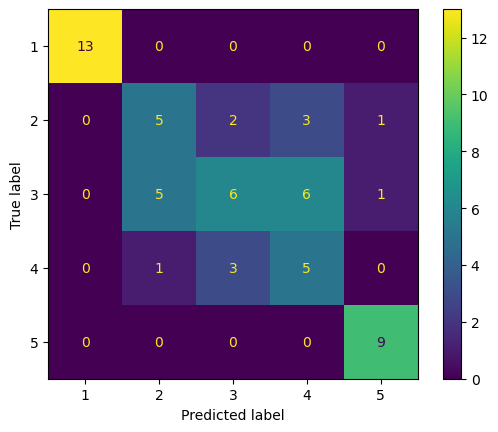

In [26]:
# plot a confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(clf, test_text_ft, test_label)